# 数据集:Trending YouTube Video Statistics

## 高威 3120211002

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math

### 1.读取数据集

In [25]:
dataset = pd.read_csv('CAvideos.csv')
dataset.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


### 2.对数据集进行处理，转换成适合进行关联规则挖掘的形式

将原数据中的多值属性转换为二值属性

原数据集共有16种属性，结合数据转换的复杂程度，此处选择8种属性转换为二值属性，其余属性为文本信息，不具备挖掘价值。
8种属性分别是：publish_time 、views、likes、dislikes、comment_count、comments_disabled、ratings_disabled、video_error_or_removed，其中：

（1）publish_time 属性，大体上分布在2017年和2018年（其他时间由于数量极少而忽略不计），这里将发布时间为2017年的用‘0’表示， 发布时间为2018年的用‘1’表示；

（2）views、likes、dislikes、comment_count四个属性均为连续型数值属性，这里将大于其‘中位数’的值表示为‘1’，小于其‘中位数’的值表示为‘0’；

（3）comments_disabled、ratings_disabled、video_error_or_removed四个属性均为布尔属性，因为绝大多数值为False,这里将取False的值表示为‘1’，取True的值表示为‘0’；

（4）category_id为连续型数值属性，且值所分布的范围较小，进行单独处理。category_id的值分布在1至43之间，且大多持集中在15~25的区间内，所以这里将其划分为三个区间，分别为1至15、 15至25、 25至43，并分别用三个二值字段category_id_1、 category_id_2、 category_id_3表示。

将多值属性转化为二值属性代码如下：

In [26]:
dataset['publish_time'] = np.where(dataset['publish_time'].str.match('2017'),0,1)

for col in ('views','likes','dislikes','comment_count'):
    dataset[col] = np.where(dataset[col] < dataset[col].median(),0,1)

for col in ('comments_disabled','ratings_disabled','video_error_or_removed'):
    dataset[col] = np.where(dataset[col]==False,1,0)

dataset['category_id_1']=np.where(dataset['category_id'] <= 15,1,0)
dataset['category_id_2']=np.where(((dataset['category_id'] > 15) & (dataset['category_id'] <= 25)),1,0)
dataset['category_id_3']=np.where(dataset['category_id'] > 25,1,0)

data_bool = dataset[['video_id','publish_time', 'views', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled','video_error_or_removed','category_id_1','category_id_2','category_id_3']]
data_bool.head()

,video_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_id_1,category_id_2,category_id_3
0,n1WpP7iowLc,0,1,1,1,1,1,1,1,1,0,0
1,0dBIkQ4Mz1M,0,1,1,1,1,1,1,1,0,1,0
2,5qpjK5DgCt4,0,1,1,1,1,1,1,1,0,1,0
3,d380meD0W0M,0,1,1,1,1,1,1,1,0,1,0
4,2Vv-BfVoq4g,0,1,1,1,1,1,1,1,1,0,0


### 3.找出频繁模式

(1)进行第一次挖掘，找到L_1项集

In [27]:
def preProcessing(dataset, vote_1_0):
    data_pre = []
    for index, row in dataset.iterrows():
        tmp_data = []
        for i in range(1, len(row)):

            if (row[i] == vote_1_0):
                tmp_data.append(dataset.columns.values.tolist()[i])

        if (tmp_data == []):
            continue
        data_pre.append(tmp_data)
    return data_pre

def mining_first(dataset, support, confidence):
    # 第一次挖掘
    dic = {}
    count = len(dataset)
    for data_line in dataset:
        for data_item in data_line:
            if (data_item in dic):
                dic[data_item] += 1
            else:
                dic[data_item] = 1

    assert (support >= 0) and (support <= 1), 'support must be in 0-1'
    val_support = int(count * support)
    assert (confidence >= 0) and (confidence <= 1), 'confidence must be in 0-1'
    dic_1 = {}
    for item in dic:
        if (dic[item] >= val_support):
            dic_1[item] = dic[item]

    return dic_1

# 支持度
support = 0.3
# 置信度
confidence = 0.8
data_1 = preProcessing(data_bool, 1) #按照1寻找关联规则
dic_1 = mining_first(data_1, support, confidence)
print('L_1项集：')
print(dic_1)


L_1项集：
{'views': 20441, 'likes': 20441, 'dislikes': 20454, 'comment_count': 20443, 'comments_disabled': 40298, 'ratings_disabled': 40602, 'video_error_or_removed': 40854, 'category_id_2': 30011, 'publish_time': 30981}


(2)进行第二次挖掘，找到L_2项集

In [28]:
def mining_second(dataset, dic_before, support, confidence):
    # 第二次挖掘
    dic = {}
    count = len(dataset)
    count2 = 0
    for data_line in dataset:
        # 获取元素数量
        count_item = len(data_line)
        # 每两个组合计数
        for i in range(0, count_item - 1):
            for j in range(i + 1, count_item):
                if (data_line[i] in dic_before and data_line[j] in dic_before):
                    count2 += 1
                    tmp = (data_line[i], data_line[j])
                    if (tmp in dic):
                        dic[tmp] += 1
                    else:
                        dic[tmp] = 1
                else:
                    continue
    # print(dic)
    assert (support >= 0) and (support <= 1), 'support must be in 0-1'
    assert (confidence >= 0) and (confidence <= 1), 'confidence must be in 0-1'

    dic_2 = {}
    for item in dic:
        count_item0 = dic_before[item[0]]
        count_item1 = dic_before[item[1]]
        # 判断 支持度 和 置信度
        if ((dic[item] >= support * count) and (
                (dic[item] >= confidence * count_item0) or (dic[item] >= confidence * count_item1))):
            dic_2[item] = dic[item]

    return dic_2

dic_2 = mining_second(data_1, dic_1, support, confidence)
print('L_2项集：')
print(dic_2)

L_2项集：
{('views', 'likes'): 16372, ('views', 'dislikes'): 17371, ('views', 'comments_disabled'): 20208, ('views', 'ratings_disabled'): 20348, ('views', 'video_error_or_removed'): 20426, ('likes', 'comment_count'): 17053, ('likes', 'comments_disabled'): 20286, ('likes', 'ratings_disabled'): 20441, ('likes', 'video_error_or_removed'): 20428, ('dislikes', 'comments_disabled'): 20245, ('dislikes', 'ratings_disabled'): 20454, ('dislikes', 'video_error_or_removed'): 20439, ('comment_count', 'comments_disabled'): 20443, ('comment_count', 'ratings_disabled'): 20388, ('comment_count', 'video_error_or_removed'): 20430, ('comments_disabled', 'ratings_disabled'): 40082, ('comments_disabled', 'video_error_or_removed'): 40271, ('ratings_disabled', 'video_error_or_removed'): 40575, ('comments_disabled', 'category_id_2'): 29497, ('ratings_disabled', 'category_id_2'): 29770, ('video_error_or_removed', 'category_id_2'): 29998, ('publish_time', 'comments_disabled'): 30514, ('publish_time', 'ratings_disab

(3)进行第三次挖掘，找到L_3项集或L_4项集至L_n

In [29]:
def mining_third(dataset, dic_before, support, confidencecoincidence):
    # 第三次挖掘
    dic_3 = {}
    for item0 in dic_before:
        for item1 in dic_before:
            if (item0 != item1):
                # print(item0,item1)
                item_len = len(item0)
                equal = True
                tmp_item3 = []
                # 判断前n-1项是否一致
                for i in range(item_len - 1):
                    tmp_item3.append(item0[i])
                    if (item0[i] != item1[i]):
                        equal = False
                        break
                if (equal == True):
                    minitem = min(item0[-1], item1[-1])
                    maxitem = max(item0[-1], item1[-1])
                    tmp_item3.append(minitem)
                    tmp_item3.append(maxitem)
                    tmp_item3 = tuple(tmp_item3)
                    dic_3[tmp_item3] = 0
                else:
                    continue
    # print('dic_3:',dic_3)
    for data_line in dataset:
        for item in dic_3:
            is_in = True
            for i in range(len(item)):
                if (item[i] not in data_line):
                    is_in = False

            if (is_in == True):
                dic_3[item] += 1

    assert (support >= 0) and (support <= 1), 'support must be in 0-1'
    assert (confidencecoincidence >= 0) and (confidence <= 1), 'confidence must be in 0-1'

    count = len(dataset)
    dic_3n = {}
    for item in dic_3:
        count_item0 = dic_before[item[:-1]]
        # 判断 支持度 和 置信度
        if ((dic_3[item] >= support * count) and (dic_3[item] >= confidence * count_item0)):
            dic_3n[item] = dic_3[item]

    return dic_3n
    pass

dic_r = []
n = 3
while (dic_2 != {}):
    dic_r.append(dic_2)
    dic_3 = mining_third(data_1, dic_2, support, confidence)
    dic_2 = dic_3
    print('L_{}项集：'.format(n))
    print(dic_2)
    n = n+1

L_3项集：
{('views', 'dislikes', 'likes'): 14731, ('views', 'comments_disabled', 'likes'): 16221, ('views', 'likes', 'ratings_disabled'): 16372, ('views', 'likes', 'video_error_or_removed'): 16360, ('views', 'comments_disabled', 'dislikes'): 17194, ('views', 'dislikes', 'ratings_disabled'): 17371, ('views', 'dislikes', 'video_error_or_removed'): 17357, ('views', 'comments_disabled', 'ratings_disabled'): 20157, ('views', 'comments_disabled', 'video_error_or_removed'): 20193, ('views', 'ratings_disabled', 'video_error_or_removed'): 20333, ('likes', 'comment_count', 'comments_disabled'): 17053, ('likes', 'comment_count', 'ratings_disabled'): 17053, ('likes', 'comment_count', 'video_error_or_removed'): 17040, ('likes', 'comments_disabled', 'ratings_disabled'): 20286, ('likes', 'comments_disabled', 'video_error_or_removed'): 20273, ('likes', 'ratings_disabled', 'video_error_or_removed'): 20428, ('dislikes', 'comments_disabled', 'ratings_disabled'): 20245, ('dislikes', 'comments_disabled', 'vid

### 4.导出关联规则，计算其支持度和置信度;使用lift和cosine对规则进行评价；对挖掘结果进行分析

In [30]:
# 定义连接函数
def connect_string(x, ms):
    x = list(map(lambda i:sorted(i.split(ms)), x))
    l = len(x[0])
    r = []
    for i in range(len(x)):
        for j in range(i,len(x)):
            if x[i][:l-1] == x[j][:l-1] and x[i][l-1] != x[j][l-1]:
                r.append(x[i][:l-1]+sorted([x[j][l-1],x[i][l-1]]))
    return r


# 定义寻找关联规则的函数
def find_rule(d, support, confidence,ms= u'-->'):
    import time
    start = time.perf_counter()
    result = pd.DataFrame(index=['support', 'confidence','lift','cosine'])  # 定义输出结果
    col_name= d.columns.values.tolist()
    support_series = pd.Series(map(lambda x: x/len(d), 1.0*d.sum()),index=col_name)  # 支持度序列
    #print(support_series)
    column = list(support_series[support_series > support].index)  # 初步根据支持度筛选
    #print(column)
    k = 0
    while len(column) > 1:
        k = k + 1
        print(u'\n正在寻找候选%s项集...' % (k+1))
        column = connect_string(column, ms)
        print(u'数目：%s...' % len(column))
        sf = lambda i: d[i].prod(axis=1, numeric_only=True)  # 新一批支持度的计算函数

        # 创建连接数据
        d_2 = pd.DataFrame(list(map(sf, column)), index=[ms.join(i) for i in column]).T
        col_name_2=d_2.columns.values.tolist()

        support_series_2 = pd.Series(map(lambda x: x / len(d),1.0 * d_2[[ms.join(i) for i in column]].sum()),index=col_name_2)  # 计算连接后的支持度
        #print(support_series_2)
        column = list(support_series_2[support_series_2 > support].index)  # 新一轮支持度筛选
        #print(column)
        support_series = support_series.append(support_series_2)
        #print(support_series)
        column2 = []

        for i in column:  # 遍历可能的推理
            i = i.split(ms)
            for j in range(len(i)):
                column2.append(i[:j] + i[j + 1:] + i[j:j + 1])
        #print(column2)

        cofidence_series = pd.Series(index=[ms.join(i) for i in column2])  # 定义置信度序列
        lift_series = pd.Series(index=[ms.join(i) for i in column2])
        cosine_series = pd.Series(index=[ms.join(i) for i in column2])
        #print(cofidence_series)

        for i in column2:  # 计算置信度序列
            #print(i)
            cofidence_series[ms.join(i)] = support_series[ms.join(sorted(i))] / support_series[ms.join(i[:len(i) - 1])]
            lift_series[ms.join(i)] = cofidence_series[ms.join(i)] / support_series[i[-1]]
            cosine_series[ms.join(i)] = support_series[ms.join(sorted(i))] / math.sqrt(support_series[ms.join(i[:len(i) - 1])]*support_series[i[-1]])
            


        for i in cofidence_series[cofidence_series > confidence].index:  # 置信度筛选
            result[i] = 0.0
            result[i]['confidence'] = cofidence_series[i]
            result[i]['support'] = support_series[ms.join(sorted(i.split(ms)))]
            result[i]['lift'] = lift_series[i]
            result[i]['cosine'] = cosine_series[i]

    result = result.T.sort_values(['confidence', 'support','lift','cosine'], ascending=False)  # 结果整理，输出
    end = time.perf_counter()
    print(u'\n搜索完成，用时：%0.2f秒' % (end - start))
    print(u'\n结果为：')
    print(result)
    return result

used_data_bool = data[['publish_time', 'views', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled',
            'video_error_or_removed','category_id_1','category_id_2','category_id_3']]
result = find_rule(used_data_bool,support,confidence,'-->')#最小置信度和支持度维持原数
result/home/r-dog


正在寻找候选2项集...
数目：36...

正在寻找候选3项集...
数目：84...

正在寻找候选4项集...
数目：83...

正在寻找候选5项集...
数目：38...

正在寻找候选6项集...
数目：9...

正在寻找候选7项集...
数目：1...

搜索完成，用时：5.42秒

结果为：
                                                     support  confidence  \
dislikes-->ratings_disabled                         0.500330    1.000000   
comment_count-->comments_disabled                   0.500061    1.000000   
likes-->ratings_disabled                            0.500012    1.000000   
dislikes-->video_error_or_removed-->ratings_dis...  0.499963    1.000000   
comment_count-->video_error_or_removed-->commen...  0.499743    1.000000   
likes-->video_error_or_removed-->ratings_disabled   0.499694    1.000000   
comment_count-->ratings_disabled-->comments_dis...  0.498716    1.000000   
comment_count-->ratings_disabled-->video_error_...  0.498398    1.000000   
comments_disabled-->likes-->ratings_disabled        0.496221    1.000000   
comments_disabled-->likes-->video_error_or_remo...  0.495903    1.000000   
comment

,support,confidence,lift,cosine
dislikes-->ratings_disabled,0.500330,1.000000,1.006872,0.709766
comment_count-->comments_disabled,0.500061,1.000000,1.014467,0.712247
likes-->ratings_disabled,0.500012,1.000000,1.006872,0.709541
dislikes-->video_error_or_removed-->ratings_disabled,0.499963,1.000000,1.006872,0.709506
comment_count-->video_error_or_removed-->comments_disabled,0.499743,1.000000,1.014467,0.712020
likes-->video_error_or_removed-->ratings_disabled,0.499694,1.000000,1.006872,0.709315
comment_count-->ratings_disabled-->comments_disabled,0.498716,1.000000,1.014467,0.711288
comment_count-->ratings_disabled-->video_error_or_removed-->comments_disabled,0.498398,1.000000,1.014467,0.711061
comments_disabled-->likes-->ratings_disabled,0.496221,1.000000,1.006872,0.706845
comments_disabled-->likes-->video_error_or_removed-->ratings_disabled,0.495903,1.000000,1.006872,0.706619


通过评价后可以看出，并非每个规则都是有意义的，因此通过lift和cosine对规则进行过滤

In [32]:
result_interest=pd.DataFrame(result[(result.lift > 1.6) & (result.cosine < 0.7)])
print(result_interest)

                                                     support  confidence  \
likes-->publish_time-->views                        0.301534    0.806213   
likes-->publish_time-->ratings_disabled-->views     0.301534    0.806213   
likes-->publish_time-->video_error_or_removed--...  0.301240    0.806114   
likes-->publish_time-->ratings_disabled-->video...  0.301240    0.806114   

                                                        lift    cosine  
likes-->publish_time-->views                        1.612387  0.697273  
likes-->publish_time-->ratings_disabled-->views     1.612387  0.697273  
likes-->publish_time-->video_error_or_removed--...  1.612188  0.696890  
likes-->publish_time-->ratings_disabled-->video...  1.612188  0.696890  


可以发现，经过过滤后数据量大大减少。

### 5.可视化展示

（1）分析confidence和cosine之间的分布关系：

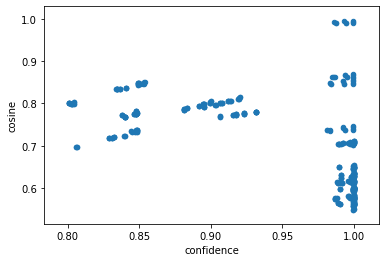

In [34]:
result.plot.scatter(x='confidence', y='cosine')
plt.show()

可以看出，总体趋势离散，无明显的线性关系

（2）分析support和lift之间的分布关系：

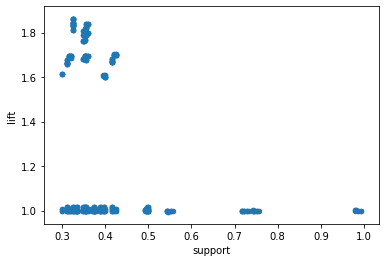

In [36]:
result.plot.scatter(x='support', y='lift')
plt.show()

可以看出，lift较高的规则分布在support较低的位置

（3）分析support和cosine之间的分布关系：

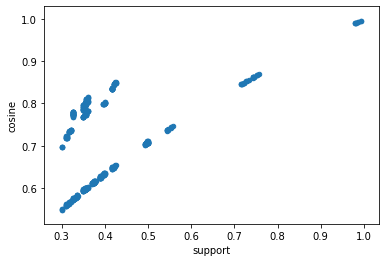

In [37]:
result.plot.scatter(x='support', y='cosine')
plt.show()

可以看出，总体有正相关关系

（4）分析confidence和lift之间的分布关系

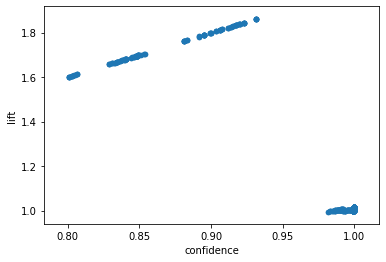

In [38]:
result.plot.scatter(x='confidence', y='lift')
plt.show()

可以看出，随着confidence的增大，lift总体也在增大